In [ ]:
#This python notebook uses OpenCV libraries, so please install all necessary libraries and dependency
#before running this notebook. In this notebook, the characters are recognized from the handwritten images.
#https://docs.opencv.org/4.x/d4/db1/tutorial_documentation.html
#https://www.tensorflow.org/api_docs/python/tf

In [1]:
#Import essential libraries
from tensorflow.keras.models import load_model
import tensorflow as tf
import cv2
import matplotlib.pyplot as plt

import imutils
from imutils.contours import sort_contours

Init Plugin
Init Graph Optimizer
Init Kernel


In [11]:
# loads the model with the keras load_model function
model_path = 'model1.h5'
print("Loading NN model...")
model = load_model(model_path)
print("Done")


Loading NN model...
Done


In [24]:
# loads the input image
image_path = "ex6.png"
image = cv2.imread(image_path)
#from google.colab import files
#image = files.upload() 

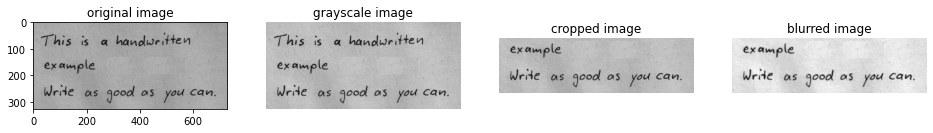

In [25]:
#pre-processing on image
gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
cropped = gray[120:,:]
blurred = cv2.GaussianBlur(cropped, (5, 5), 0)


%matplotlib inline
from matplotlib import cm
fig = plt.figure(figsize=(16,4))
ax = plt.subplot(1,4,1)
ax.imshow(image)
ax.set_title('original image');

ax = plt.subplot(1,4,2)
ax.imshow(gray,cmap=cm.binary_r)
ax.set_axis_off()
ax.set_title('grayscale image');

ax = plt.subplot(1,4,3)
ax.imshow(cropped,cmap=cm.binary_r)
ax.set_axis_off()
ax.set_title('cropped image');

ax = plt.subplot(1,4,4)
ax.imshow(blurred,cmap=cm.binary_r)
ax.set_axis_off()
ax.set_title('blurred image');
#plt.imshow(gray,cmap=cm.binary_r)

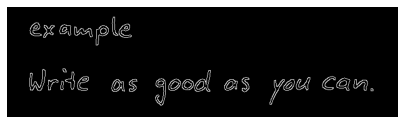

In [26]:
# perform edge detection which is in OpenCV.canny() documentation, find contours in the edge map, and sort the
# resulting contours from left-to-right
edged = cv2.Canny(blurred, 30, 250) #low_threshold, high_threshold
cnts = cv2.findContours(edged.copy(), cv2.RETR_EXTERNAL,cv2.CHAIN_APPROX_SIMPLE)
cnts = imutils.grab_contours(cnts)
cnts = sort_contours(cnts, method="left-to-right")[0]

figure = plt.figure(figsize=(7,7))
plt.axis('off');
plt.imshow(edged,cmap=cm.binary_r);

In [27]:
import numpy as np
chars = []
# loop over the contours
for c in cnts:
    # compute the bounding box of the contour and isolate ROI
    (x, y, w, h) = cv2.boundingRect(c)
    roi = cropped[y:y + h, x:x + w]
    #binarize image, finds threshold with OTSU method
    thresh = cv2.threshold(roi, 0, 255,cv2.THRESH_BINARY_INV | cv2.THRESH_OTSU)[1]
    # resize largest dimension to input size
    (tH, tW) = thresh.shape
    if tW > tH:
        thresh = imutils.resize(thresh, width=28)
    # otherwise, resize along the height
    else:
        thresh = imutils.resize(thresh, height=28)

    # find how much is needed to pad
    (tH, tW) = thresh.shape
    dX = int(max(0, 28 - tW) / 2.0)
    dY = int(max(0, 28 - tH) / 2.0)
    # pad the image and force 28 x 28 dimensions
    padded = cv2.copyMakeBorder(thresh, top=dY, bottom=dY,
    left=dX, right=dX, borderType=cv2.BORDER_CONSTANT,
    value=(0, 0, 0))
    padded = cv2.resize(padded, (28, 28))
    # reshape and rescale padded image for the model
    padded = padded.astype("float32") / 255.0
    padded = np.expand_dims(padded, axis=2)
    # append image and bounding box data in char list
    chars.append((padded, (x, y, w, h)))

/var/folders/vq/2bxcxlmn22dbbqpnjlsnx0h80000gn/T/ipykernel_698/1722485101.py:3: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  n_rows = np.int(len(chars)/ n_cols)+1


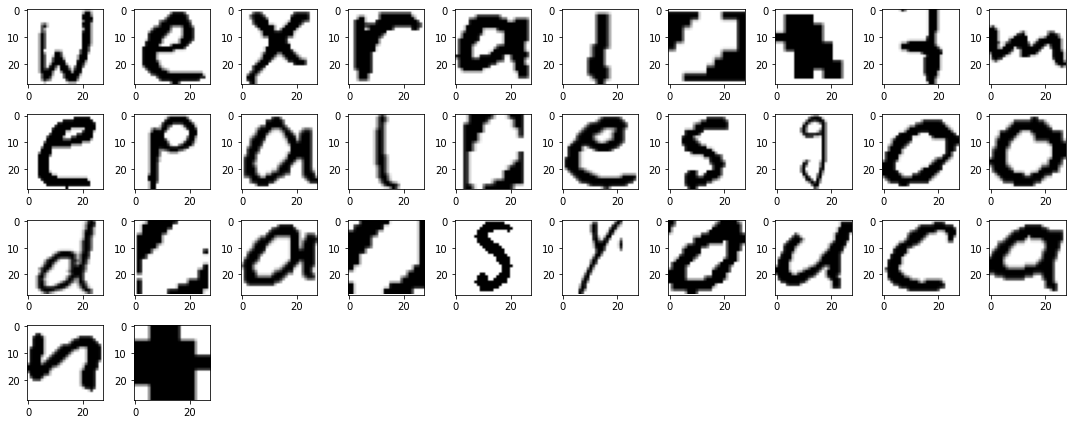

In [28]:
# plot isolated characters
n_cols = 10
n_rows = np.int(len(chars)/ n_cols)+1
fig = plt.figure(figsize=(1.5*n_cols,1.5*n_rows))
for i,char in enumerate(chars):
    ax = plt.subplot(n_rows,n_cols,i+1)
    ax.imshow(char[0][:,:,0],cmap=cm.binary,aspect='auto')
    #plt.axis('off')
plt.tight_layout()

In [29]:
boxes = [b[1] for b in chars]
chars = np.array([c[0] for c in chars], dtype="float32")
# OCR the characters using our handwriting recognition model
preds = model.predict(chars)
# define the list of label names
labelNames = "ABCDEFGHIJKLMNOPQRSTUVWXYZ0123456789"

2021-12-15 19:31:06.073711: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


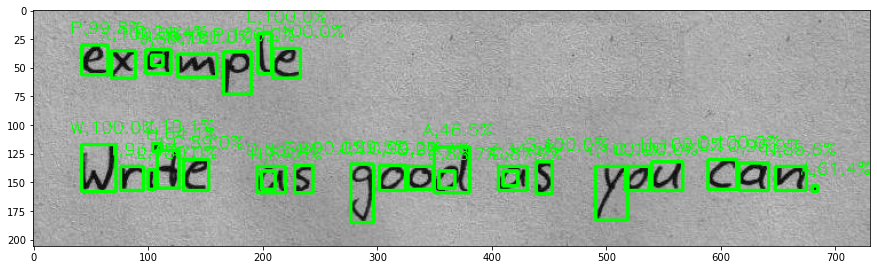

In [30]:
image = cv2.imread(image_path)
cropped = image[120:,:]

for (pred, (x, y, w, h)) in zip(preds, boxes):
    # find the index of the label with the largest corresponding
    # probability, then extract the probability and label
    i = np.argmax(pred)
    prob = pred[i]
    label = labelNames[i]
    # draw the prediction on the image and it's probability
    label_text = f"{label},{prob * 100:.1f}%"
    cv2.rectangle(cropped, (x, y), (x + w, y + h), (0,255 , 0), 2)
    cv2.putText(cropped, label_text, (x - 10, y - 10),cv2.FONT_HERSHEY_SIMPLEX,0.5, (0,255, 0), 1)
# show the image
plt.figure(figsize=(15,10))
plt.imshow(cropped)